##### Imports

In [127]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import yaml
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import block_diag
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from JOPLEn.multitask import MTJOPLEn
from JOPLEn.partitioner import VPartition, LinearForestPartition, GBPartition
from JOPLEn.enums import NormType
from sklearn.ensemble import GradientBoostingRegressor
from JOPLEn.singletask import JOPLEn
from collections import defaultdict
from JOPLEn.multitask import MTJOPLEn
from tqdm import trange


DATA_PATH = Path("..") / "datasets"

SARCOS_PATH = DATA_PATH / "sarcos" / "processed"
PARKINSONS_PATH = DATA_PATH / "parkinsons" / "processed"
NANO_PATH = DATA_PATH / "nanoparticle" / "processed"

NAMES = [
    "Dummy",
    "Linear",
    "Gradient Boosting",
    "JOPLEn",
    "Dirty LASSO",
]

OUT_PATH = Path("experiments") / "manual" / "multitask"

##### Function definitions

In [30]:
def train_model(ModelClass, x_train, y_train, x_val, y_val, x_test, y_test, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(len(x_train))):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return pd.DataFrame(output).T

In [31]:
def jp_mask(jp_model):
    core_mask = np.linalg.norm(jp_model.cwb.get()[:, :-1], axis=(0, 2)) > 1e-4
    task_mask = np.linalg.norm(jp_model.cws.get()[:, :-1], axis=2) > 1e-4

    task_mask = task_mask & ~core_mask[None, :]

    return core_mask, task_mask


def dl_mask(dl_model):
    core_mask = np.any(np.abs(dl_model.coef_shared_.T) > 1e-4, axis=0)
    task_mask = np.abs(dl_model.coef_specific_.T) > 1e-4

    task_mask = task_mask & ~core_mask[None, :]

    return core_mask, task_mask

In [32]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def dl_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2, axis=1)


def score_dl(model, x_train, y_train, x_val, y_val, x_test, y_test, masks=None):
    if masks is not None and len(masks) != 3:
        raise ValueError("You should include train, val, and test masks")

    if masks is None:
        train_mask = np.ones(x_train.shape[:2], dtype=bool)
        val_mask = np.ones(x_val.shape[:2], dtype=bool)
        test_mask = np.ones(x_test.shape[:2], dtype=bool)
    else:
        train_mask, val_mask, test_mask = masks

    y_train_err, y_val_err, y_test_err = [], [], []

    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    y_test_pred = model.predict(x_test)

    for i in range(x_train.shape[0]):
        y_train_err.append(
            mse(y_train[i, train_mask[i]], y_train_pred[i, train_mask[i]])
        )
        y_val_err.append(mse(y_val[i, val_mask[i]], y_val_pred[i, val_mask[i]]))
        y_test_err.append(mse(y_test[i, test_mask[i]], y_test_pred[i, test_mask[i]]))

    columns = ["train", "val", "test"]
    index = [f"task {i}" for i in range(x_train.shape[0])]

    return pd.DataFrame(
        np.array([y_train_err, y_val_err, y_test_err]).T,
        columns=columns,
        index=index,
    )


def dl_plot(model):
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)

    axs[0].matshow(model.coef_shared_)
    axs[0].set_title("Shared Coefficients")

    axs[1].matshow(model.coef_specific_)
    axs[1].set_title("Specific Coefficients")

    for ax in axs:
        ax.set_ylabel("Features")
        ax.set_xlabel("Tasks")

    plt.tight_layout()

    core_mask, task_mask = dl_mask(model)

    print("Core features:", np.sum(core_mask))
    print(f"Task features: {list(np.sum(task_mask, axis=1))}: {np.sum(task_mask)}")

In [33]:
def scale_matrix(matrix, min_val, max_val):
    # Create an empty matrix of the same shape to store the scaled values
    scaled_matrix = np.zeros_like(matrix)

    assert min_val < 0 and max_val > 0, "min_val and max_val must have opposite signs"

    abs_max = max(abs(min_val), abs(max_val))

    # Handle negative and zero values
    neg_mask = matrix <= 0
    scaled_matrix[neg_mask] = matrix[neg_mask] / abs_max

    # Handle positive values
    pos_mask = matrix > 0
    scaled_matrix[pos_mask] = matrix[pos_mask] / abs_max

    return scaled_matrix


def plot_joplen_weights(model, dpi=300):
    core_weights = model.cwb.get()
    task_weights = model.cws.get()

    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True, dpi=dpi)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    axs[0].set_title("Core Weights")
    axs[1].matshow(task_weights, **params)
    axs[1].set_title("Task Weights")

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    for ax in axs:
        ax.set_xlabel("Tasks, partitions, and cells")
        ax.set_ylabel("Features")

    plt.tight_layout()
    plt.show()

    # print the number of weights that are nonzero
    core_mask, task_mask = jp_mask(model)

    print(f"Number of nonzero core weights: {core_mask.sum()}")
    print(
        f"Number of nonzero task weights: {list(task_mask.sum(axis=1))}: {task_mask.sum()}"
    )

In [128]:
def score_jp(model: MTJOPLEn, x_train, y_train, x_val, y_val, x_test, y_test):
    y_train_err = []
    y_val_err = []
    y_test_err = []

    for i in range(len(x_train)):
        y_train_err.append(mse(y_train[i], model.predict(x_train[i], i).flatten()))
        y_val_err.append(mse(y_val[i], model.predict(x_val[i], i).flatten()))
        y_test_err.append(mse(y_test[i], model.predict(x_test[i], i).flatten()))

    columns = ["train", "val", "test"]
    index = [f"task {i}" for i in range(len(x_train))]

    return pd.DataFrame(
        np.array([y_train_err, y_val_err, y_test_err]).T,
        columns=columns,
        index=index,
    )


def compare_feats(jp_model, dl_model):
    jp_core_feats, jp_task_feats = jp_mask(jp_model)
    dl_core_feats, dl_task_feats = dl_mask(dl_model)

    results = [
        np.sum(jp_core_feats | jp_task_feats, axis=1),
        np.sum(dl_core_feats | dl_task_feats, axis=1),
    ]

    df = pd.DataFrame(results, columns=[f"task_{i}" for i in range(len(jp_task_feats))])
    df.index = ["JOPLEn", "Dirty LASSO"]

    return df


def train_masked_gb(
    x_train, y_train, x_val, y_val, x_test, y_test, core_mask, task_mask
):
    both_masks = core_mask | task_mask

    errors = []

    for i in trange(len(x_train)):
        model = GradientBoostingRegressor()
        model.fit(x_train[i][:, both_masks[i]], y_train[i])

        errors.append(
            {
                "train": mse(y_train[i], model.predict(x_train[i][:, both_masks[i]])),
                "val": mse(y_val[i], model.predict(x_val[i][:, both_masks[i]])),
                "test": mse(y_test[i], model.predict(x_test[i][:, both_masks[i]])),
            }
        )

    return pd.DataFrame(errors)

In [35]:
def plot_strip(
    arr: list[np.ndarray],
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    ax=None,
):
    """
    Create a strip plot based on the list of y-values.
    """
    if ax is None:
        fig, ax = plt.subplots(**plot_kwargs)

    np.random.seed(random_state)
    y_values = np.arange(len(arr))[:, None] + np.random.uniform(
        -jitter, jitter, size=arr.shape
    )

    for xs, ys in zip(arr, y_values):
        ax.scatter(xs, ys, **scatter_kwargs)

    # for x_idx, x_values in enumerate(arr):
    #     # Apply jitter to x-axis positions
    #     y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in x_values]
    #     ax.scatter(x_values, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, x_values in enumerate(arr[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    ax.set_xlim(x_lim)
    ax.set_ylim(-0.5, len(arr) - 0.5)

    return ax, y_values

In [36]:
def concat_datasets(
    X_datasets: list[np.ndarray], y_datasets: list[np.ndarray]
) -> tuple[np.ndarray]:
    padded_y = []
    padded_X = []
    mask = []

    num_datasets = len(y_datasets)
    basis = np.eye(num_datasets, dtype=bool)

    for i, (y, X, b) in enumerate(zip(y_datasets, X_datasets, basis)):
        y = np.expand_dims(y, 0)
        X = np.expand_dims(X, 0)
        b = np.expand_dims(b, 1)

        task_padding = (i, num_datasets - i - 1)

        tmp_y = np.pad(y, [task_padding, (0, 0)], mode="constant")
        tmp_X = np.tile(X, (num_datasets, 1, 1))
        tmp_b = np.tile(b, (1, y.shape[1]))

        padded_y.append(tmp_y)
        padded_X.append(tmp_X)
        mask.append(tmp_b)

    y_out = np.concatenate(padded_y, axis=-1)
    x_out = np.concatenate(padded_X, axis=1)
    mask_out = np.concatenate(mask, axis=-1)

    return x_out, y_out, mask_out


def get_out_data(y_pred, mask_out):
    indices = [0] + list(np.cumsum(mask_out.sum(axis=1)))[:-1] + [None]
    tmp = y_pred[mask_out]
    return [tmp[i1:i2] for i1, i2 in zip(indices[:-1], indices[1:])]

In [37]:
def scatter_test(x_data, y_data, x_name, y_name):
    plt.scatter(x_data["test"], y_data["test"])

    xlim, ylim = plt.xlim(), plt.ylim()

    max_val = max(xlim[1], ylim[1])

    plt.plot([0, 10], [0, 10], "k--")
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.gca().set_aspect("equal")

    plt.xlabel(x_name)
    plt.ylabel(y_name)

    plt.show()

In [38]:
def save_results(
    dataset,
    jp_res,
    dl_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
):
    path = OUT_PATH / dataset

    path.mkdir(parents=True, exist_ok=True)

    # prediction performance
    jp_res.to_csv(path / "joplen.csv")
    dl_res.to_csv(path / "dl.csv")
    dummy_results.to_csv(path / "dummy.csv")
    linear_results.to_csv(path / "linear.csv")
    gb_results.to_csv(path / "gb.csv")

    # weights
    jp_path = path / "joplen"
    jp_path.mkdir(parents=True, exist_ok=True)
    np.save(jp_path / "core.npy", jp_model.cwb.get())
    np.save(jp_path / "task.npy", jp_model.cws.get())

    dl_path = path / "dirty_lasso"
    dl_path.mkdir(parents=True, exist_ok=True)
    np.save(dl_path / "core.npy", dl_model.coef_shared_)
    np.save(dl_path / "task.npy", dl_model.coef_specific_)


def load_results(dataset):
    path = OUT_PATH / dataset

    # prediction performance
    jp_res = pd.read_csv(path / "joplen.csv", index_col=0)
    dl_res = pd.read_csv(path / "dl.csv", index_col=0)
    dummy_results = pd.read_csv(path / "dummy.csv", index_col=0)
    linear_results = pd.read_csv(path / "linear.csv", index_col=0)
    gb_results = pd.read_csv(path / "gb.csv", index_col=0)

    # weights
    jp_path = path / "joplen"
    jp_core = np.load(jp_path / "core.npy")
    jp_task = np.load(jp_path / "task.npy")

    dl_path = path / "dirty_lasso"
    dl_core = np.load(dl_path / "core.npy")
    dl_task = np.load(dl_path / "task.npy")

    return (
        jp_res,
        dl_res,
        dummy_results,
        linear_results,
        gb_results,
        jp_core,
        jp_task,
        dl_core,
        dl_task,
    )

##### SARCOS

In [39]:
# try sarcos

x_train = np.loadtxt(SARCOS_PATH / "x_train.csv", delimiter=",")
x_val = np.loadtxt(SARCOS_PATH / "x_val.csv", delimiter=",")
x_test = np.loadtxt(SARCOS_PATH / "x_test.csv", delimiter=",")

y_train = np.loadtxt(SARCOS_PATH / "y_train.csv", delimiter=",")
y_val = np.loadtxt(SARCOS_PATH / "y_val.csv", delimiter=",")
y_test = np.loadtxt(SARCOS_PATH / "y_test.csv", delimiter=",")

x_ss = StandardScaler()
x_train = x_ss.fit_transform(x_train)
x_val = x_ss.transform(x_val)
x_test = x_ss.transform(x_test)

y_ss = StandardScaler()
y_train = y_ss.fit_transform(y_train)
y_val = y_ss.transform(y_val)
y_test = y_ss.transform(y_test)

print(x_train.shape, y_train.shape)

n_tasks = y_train.shape[1]

x_train = np.tile(x_train, (n_tasks, 1, 1))
x_val = np.tile(x_val, (n_tasks, 1, 1))
x_test = np.tile(x_test, (n_tasks, 1, 1))

y_train = np.transpose(y_train)
y_val = np.transpose(y_val)
y_test = np.transpose(y_test)

print(x_train.shape, y_train.shape)

(34262, 21) (34262, 7)
(7, 34262, 21) (7, 34262)


In [40]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
linear_results = train_model(LinearRegression, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=1000,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

Dummy Results


,train,val,test
task 0,1.0,1.032,0.983
task 1,1.0,1.011,0.978
task 2,1.0,1.019,0.991
task 3,1.0,1.020,0.979
task 4,1.0,1.037,1.010
task 5,1.0,0.994,0.973
task 6,1.0,1.010,0.984


Linear Results


,train,val,test
task 0,0.074,0.074,0.074
task 1,0.103,0.102,0.102
task 2,0.091,0.094,0.090
task 3,0.051,0.053,0.050
task 4,0.146,0.151,0.144
task 5,0.274,0.277,0.271
task 6,0.065,0.067,0.064


GB Results


,train,val,test
task 0,0.004,0.016,0.014
task 1,0.003,0.013,0.012
task 2,0.003,0.010,0.010
task 3,0.001,0.004,0.004
task 4,0.004,0.016,0.015
task 5,0.005,0.018,0.018
task 6,0.002,0.007,0.007


Core features: 5
Task features: [3, 3, 3, 2, 8, 5, 3]: 27


,train,val,test
task 0,0.105,0.103,0.104
task 1,0.125,0.124,0.121
task 2,0.107,0.110,0.102
task 3,0.070,0.071,0.069
task 4,0.194,0.201,0.192
task 5,0.335,0.337,0.327
task 6,0.095,0.096,0.095


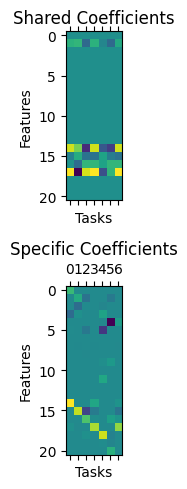

In [41]:
from mutar import DirtyModel

dl_model = DirtyModel(
    alpha=0.1,  # shared penalty
    beta=0.0442,  # task-specific penalty
)
dl_model.fit(x_train, y_train)

dl_plot(dl_model)

dl_res = score_dl(dl_model, x_train, y_train, x_val, y_val, x_test, y_test)
display(dl_res.round(3))

In [130]:
vpart_params = (
    {"n_partitions": 100, "n_cells": 8},
    {
        "max_iters": 1000,
        "lam_core": 0.7,
        "lam_task": 0.3,
        "core_alpha": 0.0,
        "task_alpha": 0.0,
        "print_epochs": 10,
        "mu": 0.1,
    },
)

jp_model = MTJOPLEn(
    GBPartition,
    # VPartition,
    **vpart_params[0],
    random_state=0,
)
history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    **vpart_params[1],
    verbose=True,
)

Partition tasks:   0%|          | 0/7 [00:00<?, ?it/s]

Partition tasks: 100%|██████████| 7/7 [01:51<00:00, 15.93s/it]


[14:34:52]: Epoch     10 | TrL: 0.589579, 0.491407, 0.433410, 0.420441, 0.508520, 0.617439, 0.429535 | VaL: 0.594906, 0.488676, 0.436020, 0.428844, 0.520120, 0.616680, 0.434382 | CNorm: 32.233925 | TNorm: 71.986244 | CFNorm: 0.707288 | TFNorm: 0.707288 | WbNz:   21 | WsNz:    0,    0,    1,    0,    0,    1,    0
[14:34:52]: Epoch     20 | TrL: 0.505939, 0.439109, 0.399818, 0.383897, 0.469117, 0.572213, 0.398077 | VaL: 0.508574, 0.436325, 0.402821, 0.391049, 0.479404, 0.572206, 0.402326 | CNorm: 35.025009 | TNorm: 75.022003 | CFNorm: 0.995693 | TFNorm: 0.995693 | WbNz:   19 | WsNz:    0,    0,    0,    0,    1,    3,    0
[14:34:52]: Epoch     30 | TrL: 0.470650, 0.419302, 0.384409, 0.365726, 0.454566, 0.555019, 0.384908 | VaL: 0.472180, 0.416738, 0.387704, 0.372353, 0.464513, 0.555355, 0.388835 | CNorm: 36.177826 | TNorm: 74.662476 | CFNorm: 1.212002 | TFNorm: 1.212002 | WbNz:   15 | WsNz:    0,    0,    1,    0,    3,    5,    0
[14:34:52]: Epoch     40 | TrL: 0.450113, 0.407845, 0.3

,train,val,test
task 0,0.127,0.126,0.124
task 1,0.135,0.133,0.130
task 2,0.115,0.118,0.110
task 3,0.092,0.095,0.089
task 4,0.182,0.189,0.184
task 5,0.269,0.272,0.258
task 6,0.118,0.120,0.118


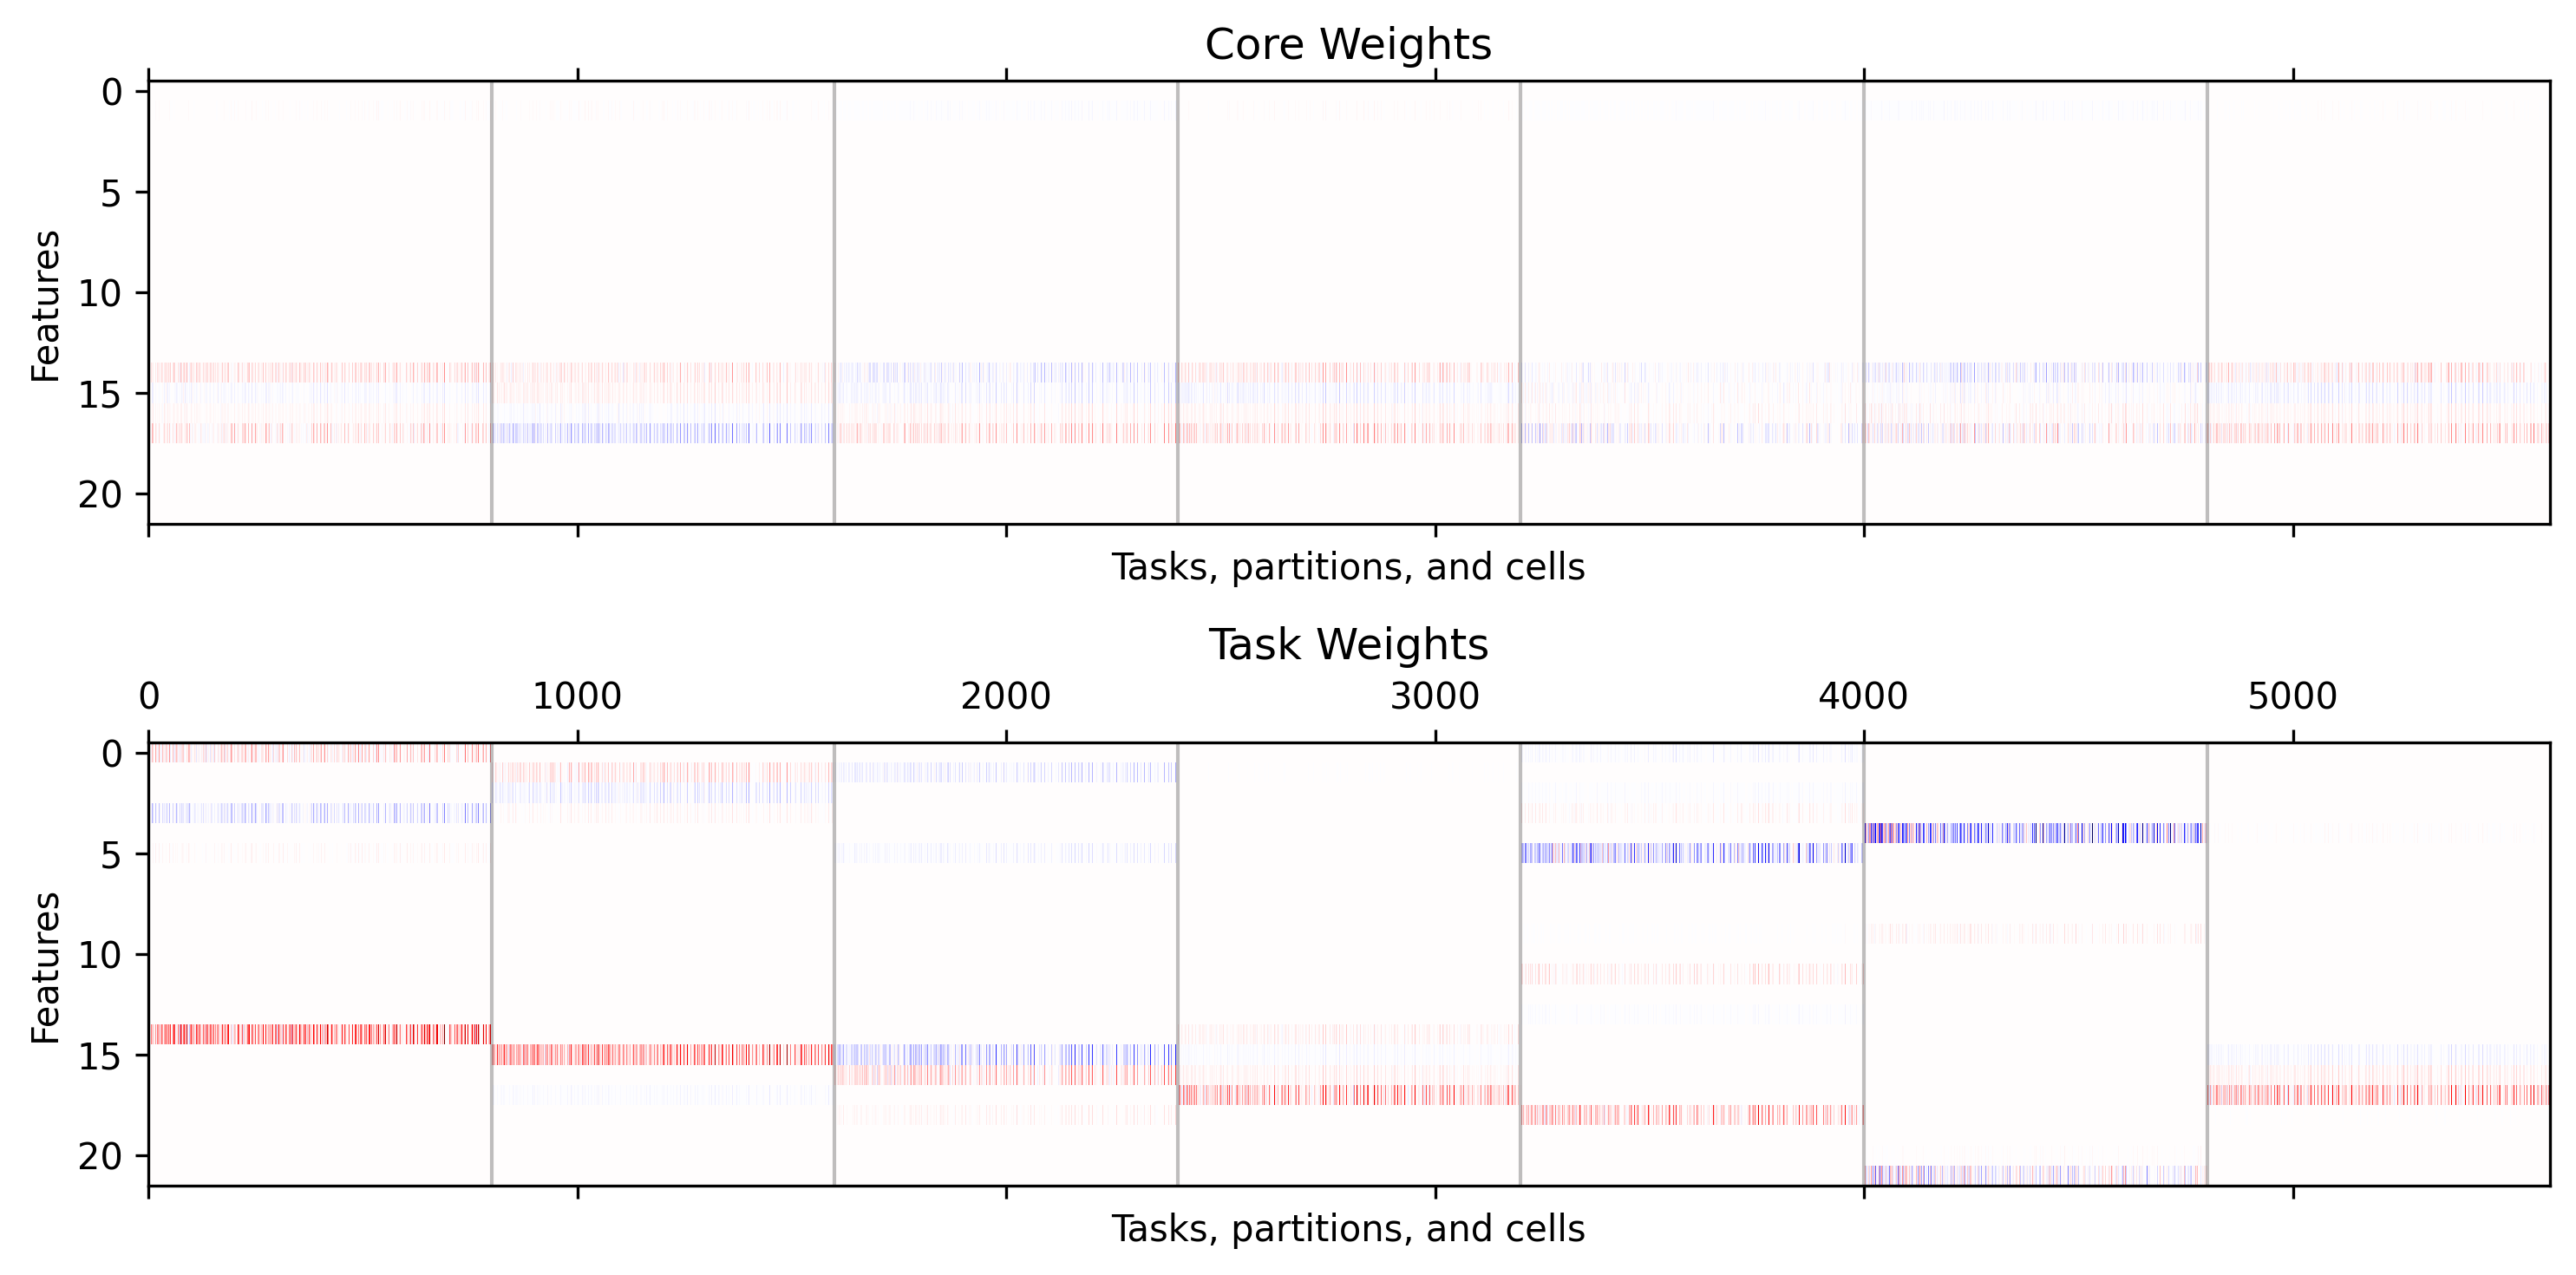

Number of nonzero core weights: 5
Number of nonzero task weights: [3, 2, 2, 0, 8, 3, 2]: 20


In [131]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model)

In [132]:
sarcos_df = compare_feats(jp_model, dl_model)
sarcos_df

,task_0,task_1,task_2,task_3,task_4,task_5,task_6
JOPLEn,8,7,7,5,13,8,7
Dirty LASSO,8,8,8,7,13,10,8


In [134]:
train_masked_gb(x_train, y_train, x_val, y_val, x_test, y_test, *jp_mask(jp_model))

100%|██████████| 7/7 [00:41<00:00,  5.95s/it]


,train,val,test
0,0.067475,0.072046,0.071489
1,0.063434,0.066259,0.065340
2,0.068246,0.073304,0.071094
3,0.045494,0.047803,0.048694
4,0.104272,0.110311,0.111236
5,0.127067,0.135689,0.129735
6,0.056778,0.059650,0.061290


In [133]:
train_masked_gb(x_train, y_train, x_val, y_val, x_test, y_test, *dl_mask(dl_model))

100%|██████████| 7/7 [00:47<00:00,  6.74s/it]


,train,val,test
0,0.067475,0.072046,0.071489
1,0.062532,0.065432,0.063806
2,0.063615,0.068646,0.067510
3,0.033592,0.035855,0.036393
4,0.082660,0.090148,0.087299
5,0.122248,0.129766,0.126178
6,0.049196,0.051793,0.052734


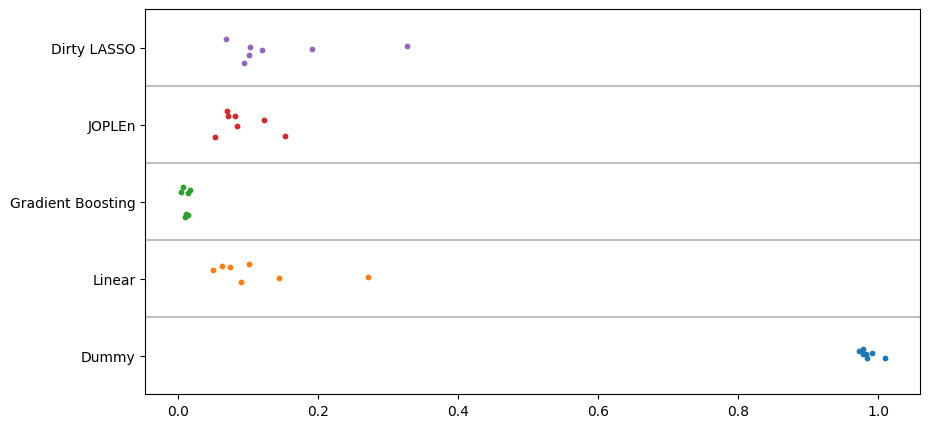

In [17]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 1.0, "s": 10},
)
plt.yticks(np.arange(len(NAMES)), NAMES)

plt.show()

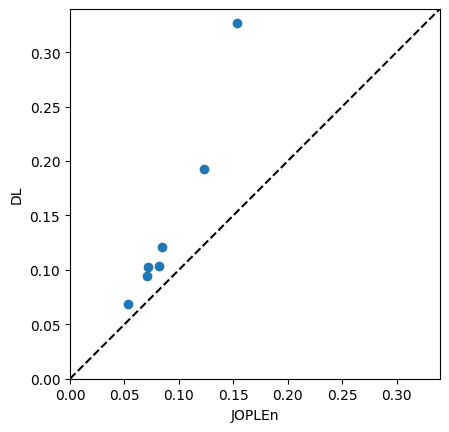

In [18]:
scatter_test(jp_res, dl_res, "JOPLEn", "DL")

In [19]:
jp_res

,train,val,test
task 0,0.083930,0.083417,0.081477
task 1,0.086667,0.085973,0.084358
task 2,0.074789,0.076615,0.071403
task 3,0.055355,0.056687,0.053647
task 4,0.119792,0.125067,0.122852
task 5,0.158691,0.161953,0.153331
task 6,0.071798,0.072320,0.070870


In [20]:
# save results for plotting
save_results(
    "sarcos",
    jp_res,
    dl_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
)

---

##### Parkinsons

In [21]:
# try parkinsons

train = {}
val = {}
test = {}

for dir in sorted(PARKINSONS_PATH.iterdir(), key=lambda x: int(x.name)):
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[int(dir.name)] = {"x": x_train, "y": y_train}
    val[int(dir.name)] = {"x": x_val, "y": y_val}
    test[int(dir.name)] = {"x": x_test, "y": y_test}

# print number of features and samples
print(x_train.shape)

(105, 18)


In [22]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [23]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
linear_results = train_model(LinearRegression, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=100,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 42/42 [00:00<00:00, 132.74it/s]

Dummy Results


,train,val,test
task 0,1.0,1.062,1.008
task 1,1.0,0.914,1.110
task 2,1.0,0.852,0.726
task 3,1.0,1.169,0.662
task 4,1.0,0.793,1.129
task 5,1.0,1.081,0.873
task 6,1.0,1.023,0.503
task 7,1.0,1.068,0.718
task 8,1.0,1.497,0.964
task 9,1.0,0.863,0.904


Linear Results


,train,val,test
task 0,0.684,1.086,1.411
task 1,0.693,0.564,0.693
task 2,0.664,1.462,0.971
task 3,0.504,0.796,0.572
task 4,0.677,1.208,0.857
task 5,0.565,2.131,1.006
task 6,0.677,1.210,0.325
task 7,0.867,1.173,0.858
task 8,0.798,1.341,0.971
task 9,0.692,1.059,1.145


GB Results


,train,val,test
task 0,0.267,1.299,1.012
task 1,0.329,0.799,0.756
task 2,0.183,0.583,0.942
task 3,0.280,0.996,0.507
task 4,0.321,1.132,1.135
task 5,0.203,1.262,0.554
task 6,0.300,1.135,0.615
task 7,0.371,0.991,1.189
task 8,0.358,1.465,0.742
task 9,0.278,1.004,0.854


In [24]:
from JOPLEn.partitioner import VPartition, RFPartition, GBPartition

jp_model = MTJOPLEn(
    GBPartition,
    n_partitions=100,
    # VPartition,
    # n_partitions=1000,
    n_cells=8,
    random_state=0,
)

history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=100,
    lam_core=4.7,
    lam_task=1.16,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=2,
    mu=0.05,
)

Partition tasks: 100%|██████████| 42/42 [00:01<00:00, 21.60it/s]


[11:04:03]: Epoch      2 | TrL: 0.969405, 0.966758, 0.955875, 0.954244, 0.964828, 0.967680, 0.971596, 0.992809, 0.980080, 0.979592, 0.967738, 0.979311, 0.963981, 0.977855, 0.875615, 0.949638, 0.981795, 0.957780, 0.979305, 0.985728, 0.974347, 0.977865, 0.935085, 0.979000, 0.957522, 0.963164, 0.950352, 0.983195, 0.972010, 0.980588, 0.971886, 0.964633, 0.958248, 0.974681, 0.984913, 0.980585, 0.877886, 0.990318, 0.987431, 0.982925, 0.981537, 0.942387 | VaL: 1.012316, 0.920942, 0.881843, 1.084556, 0.905314, 1.001650, 1.001629, 1.025716, 1.215031, 0.919087, 1.049042, 1.034802, 0.939955, 1.046621, 1.063117, 1.129363, 0.997944, 0.880278, 0.944066, 1.089679, 0.992857, 0.998445, 0.860914, 1.163477, 1.069503, 0.970538, 1.015639, 1.384291, 0.878752, 0.941253, 1.006054, 0.999544, 0.937078, 1.089767, 1.052770, 0.994708, 0.972680, 0.901832, 1.044132, 1.295485, 1.019888, 1.031676 | CNorm: 8.610773 | TNorm: 29.685709 | CFNorm: 0.025170 | TFNorm: 0.025170 | WbNz:   17 | WsNz:    0,    0,    0,    0,    

,train,val,test
task 0,0.895,1.022,1.038
task 1,0.932,0.844,1.043
task 2,0.894,0.761,0.694
task 3,0.906,1.129,0.604
task 4,0.945,0.796,1.092
task 5,0.899,0.992,0.741
task 6,0.928,0.988,0.490
task 7,0.964,1.028,0.718
task 8,0.952,1.482,0.943
task 9,0.952,0.842,0.890


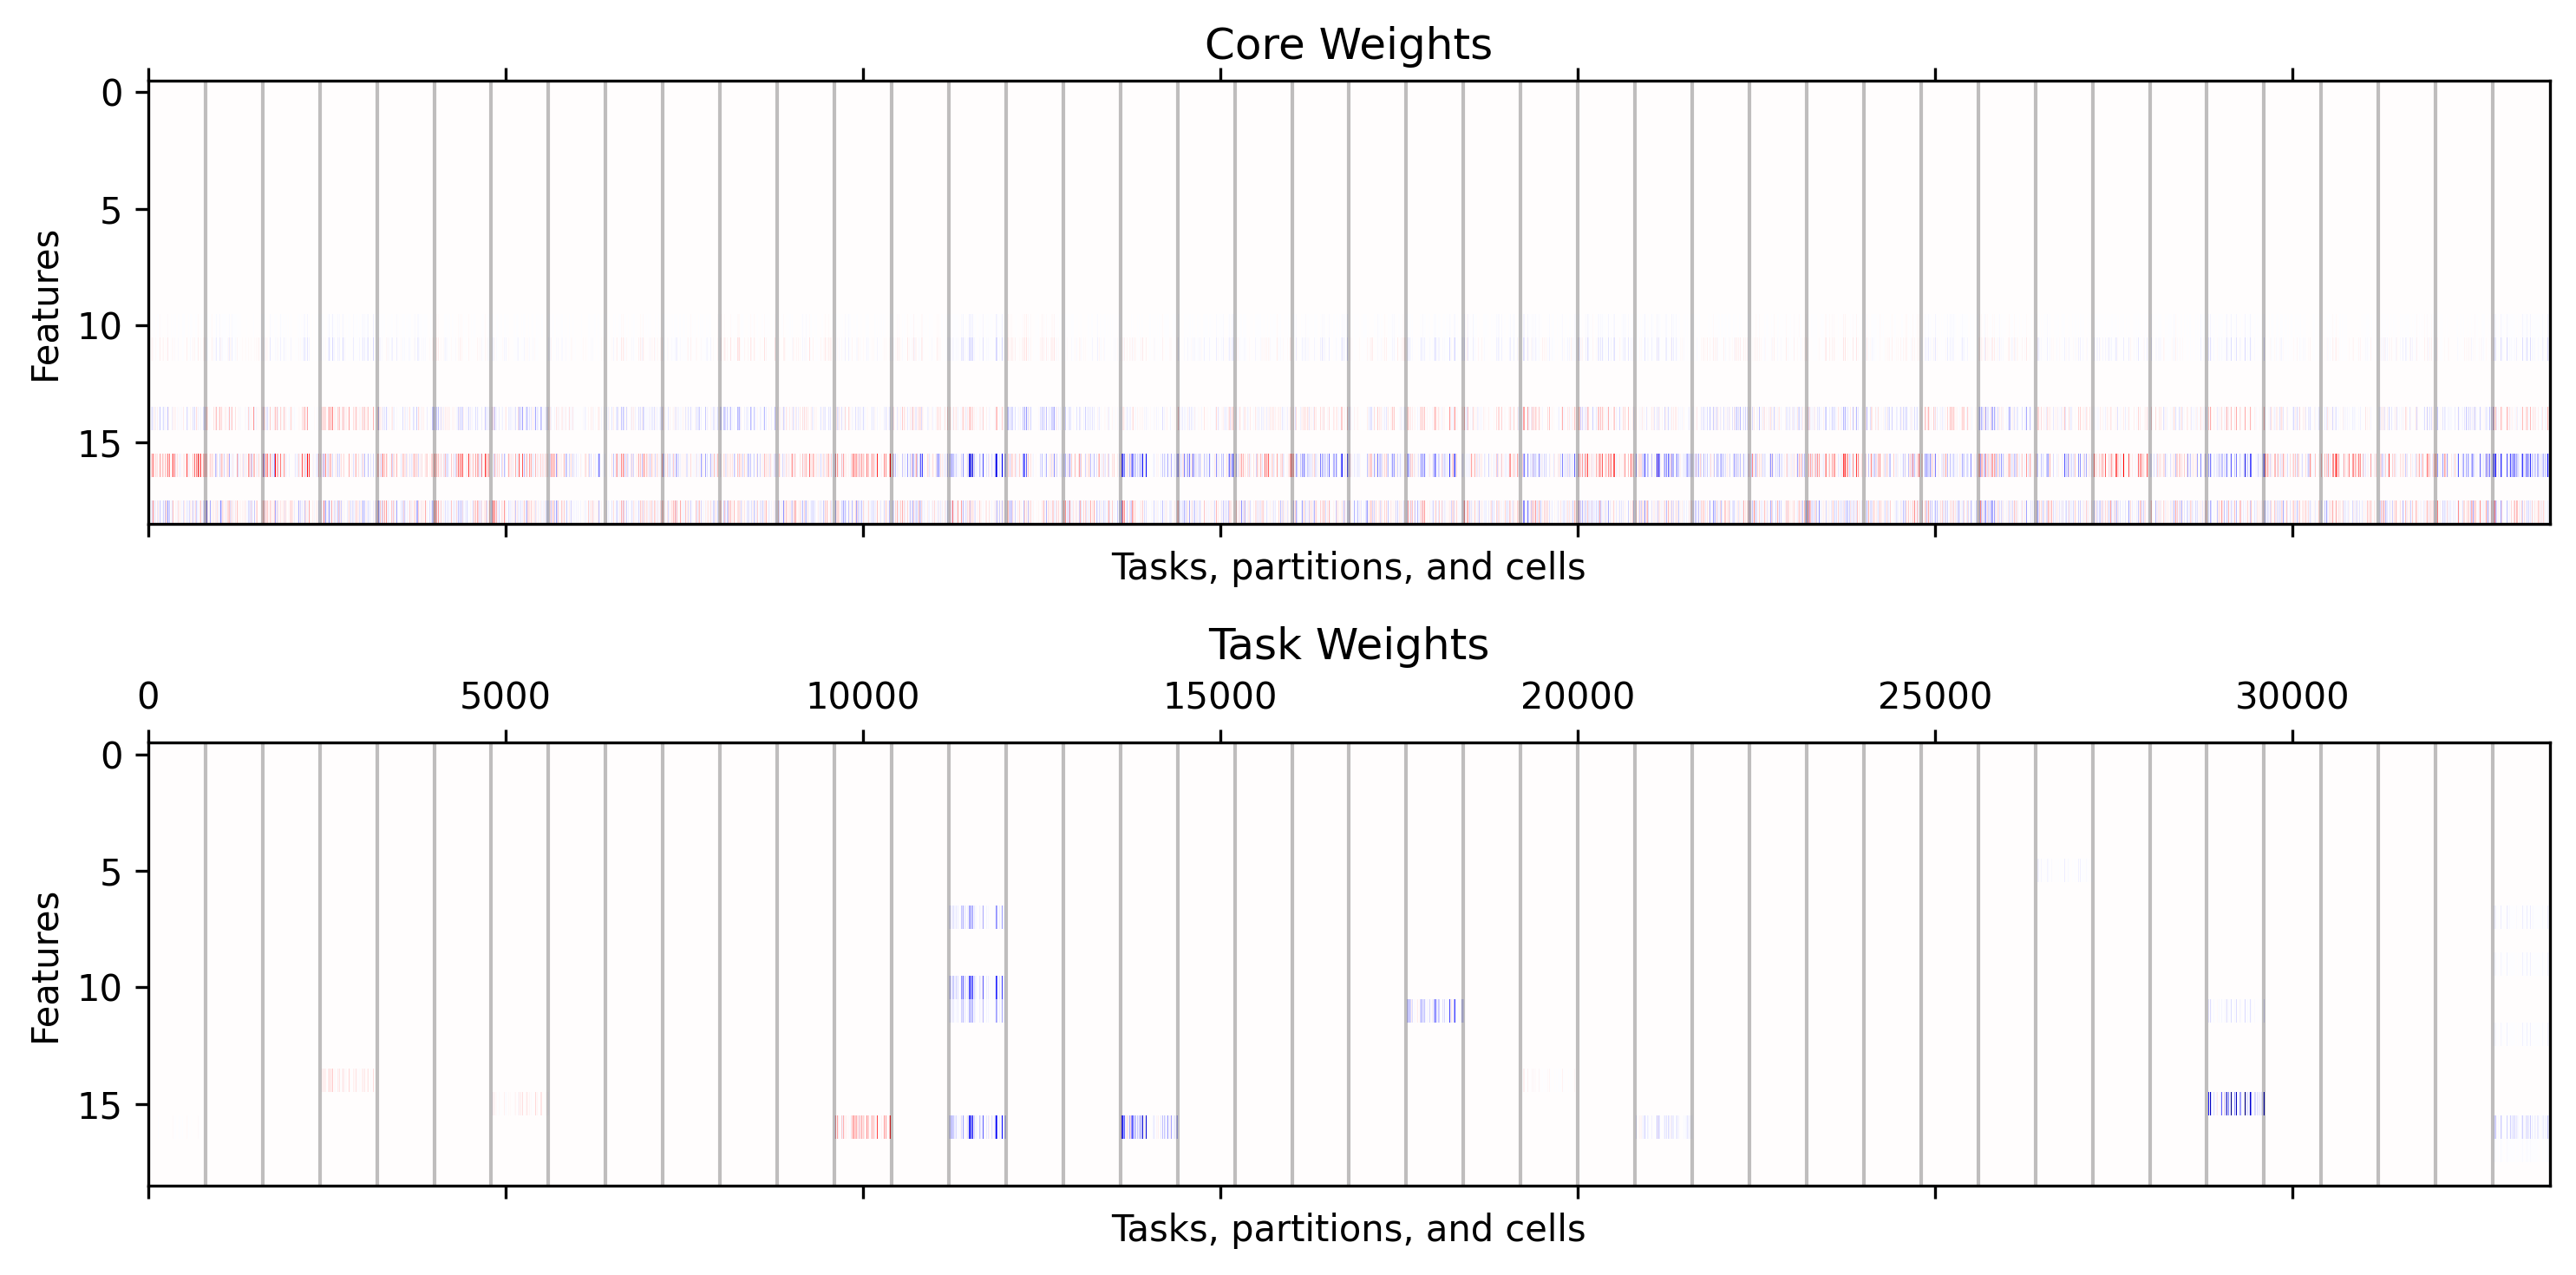

Number of nonzero core weights: 4
Number of nonzero task weights: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 4]: 8


In [25]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model)

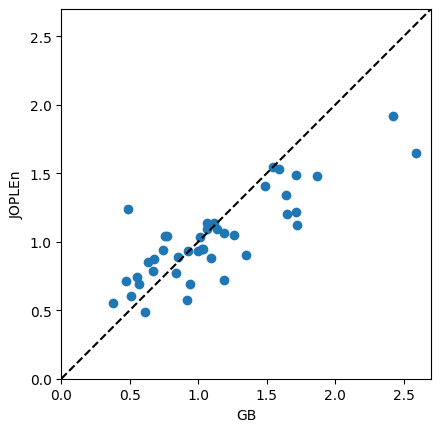

In [26]:
scatter_test(gb_results, jp_res, "GB", "JOPLEn")

In [27]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

dl_model = DirtyModel(
    alpha=0.015,  # shared penalty
    beta=0.005,  # task-specific penalty
)
dl_model.fit(x_train_out, y_train_out, train_mask_out)

TypeError: MultitaskRegression.fit() takes 3 positional arguments but 4 were given

Core features: 4
Task features: [0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]: 9


,train,val,test
task 0,0.822,0.996,1.183
task 1,0.899,0.726,0.808
task 2,0.851,0.713,0.705
task 3,0.838,1.039,0.627
task 4,0.893,0.836,1.018
task 5,0.848,0.930,0.650
task 6,0.875,0.908,0.445
task 7,0.988,1.001,0.732
task 8,0.960,1.437,0.952
task 9,0.919,0.861,0.800


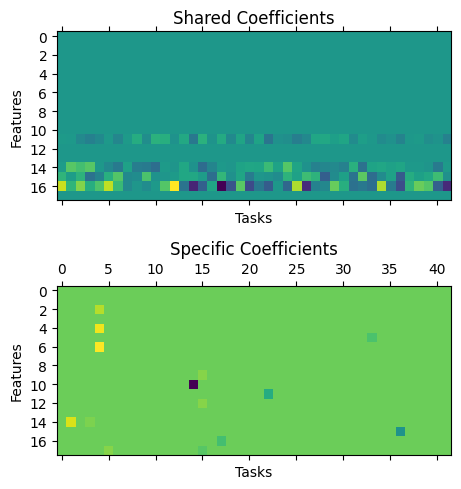

In [ ]:
dl_plot(dl_model)

dl_res = score_dl(
    dl_model,
    x_train_out,
    y_train_out,
    x_val_out,
    y_val_out,
    x_test_out,
    y_test_out,
    masks=[train_mask_out, val_mask_out, test_mask_out],
)
display(dl_res.round(3))  # 4,9

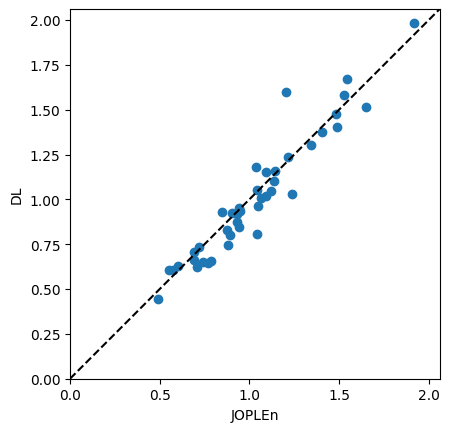

In [ ]:
scatter_test(jp_res, dl_res, "JOPLEn", "DL")

In [ ]:
feats_df = compare_feats(
    jp_model, dl_model, x_train, y_train, x_val, y_val, x_test, y_test
)
feats_df.xs("test", level=1).round(3)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
joplen,0.979,1.106,0.72,0.589,1.057,0.819,0.408,0.715,0.943,0.886,...,0.89,1.357,1.179,0.998,1.687,1.127,0.735,1.419,0.798,1.461
dl,0.979,1.106,0.72,0.589,1.057,0.819,0.408,0.715,0.943,0.886,...,0.89,1.357,1.179,0.998,1.687,1.127,0.735,1.419,0.798,1.461


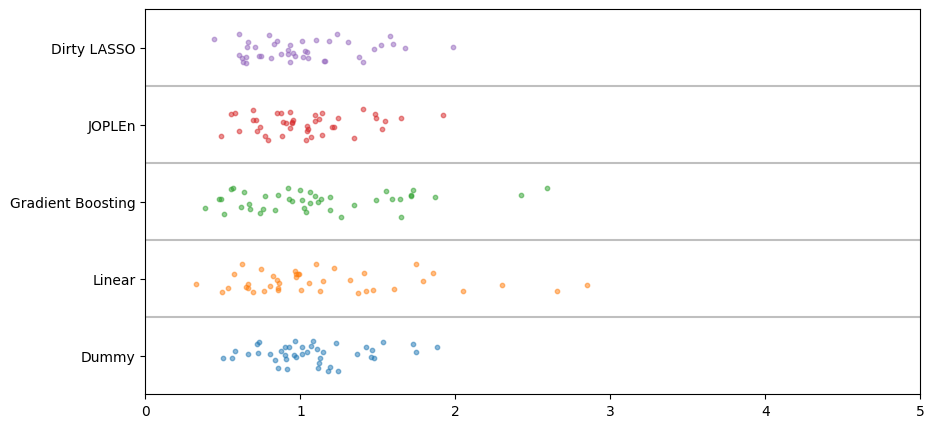

In [ ]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 0.5, "s": 10},
)
plt.yticks(np.arange(len(NAMES)), NAMES)

plt.xlim(0, 5)

plt.show()

In [ ]:
# save results for plotting
save_results(
    "parkinsons",
    jp_res,
    dl_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
)

---

##### Nanoparticle

In [ ]:
train = {}
val = {}
test = {}

dirs = sorted(NANO_PATH.iterdir())
dir_names = [dir.name for dir in dirs]

for dir in dirs:
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[dir.name] = {"x": x_train, "y": y_train}
    val[dir.name] = {"x": x_val, "y": y_val}
    test[dir.name] = {"x": x_test, "y": y_test}

    print(dir.name)

mol_boil
mol_henry
mol_logp
mol_melt
np_logp
np_zetap
protein_sol


In [ ]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [ ]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
linear_results = train_model(LinearRegression, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=1000,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 7/7 [00:33<00:00,  4.79s/it]

Dummy Results


,train,val,test
task 0,1.0,0.878,0.704
task 1,1.0,0.795,0.841
task 2,1.0,1.019,1.004
task 3,1.0,1.059,0.923
task 4,1.0,1.151,1.359
task 5,1.0,1.461,1.037
task 6,1.0,1.029,0.976


Linear Results


,train,val,test
task 0,0.252,2.140698e+20,3.308000e+00
task 1,0.069,5.001108e+19,1.077561e+20
task 2,0.295,2.850804e+18,3.320000e-01
task 3,0.230,7.332000e+00,1.044908e+19
task 4,0.000,2.482090e+02,2.798230e+02
task 5,0.000,2.722200e+01,4.019000e+00
task 6,0.629,2.533001e+20,7.125476e+19


GB Results


,train,val,test
task 0,0.000,0.582,0.518
task 1,0.000,0.252,0.191
task 2,0.001,0.214,0.222
task 3,0.000,0.313,0.312
task 4,0.000,0.243,0.333
task 5,0.000,0.389,0.323
task 6,0.012,0.773,0.858


In [ ]:
jp_model = MTJOPLEn(
    GBPartition,
    # n_partitions=100,
    # VPartition,
    n_partitions=100,
    n_cells=8,
    random_state=0,
)

history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=10000,
    lam_core=0.76,
    lam_task=0.47,
    # lam_core=1.6,
    # lam_task=1.25,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=100,
    mu=0.001,
)

[20:32:22]: Epoch    100 | TrL: 0.967095, 0.963439, 0.798847, 0.937177, 0.992641, 0.980796, 0.992026 | VaL: 0.911947, 0.863873, 0.804565, 0.962009, 1.067537, 1.204440, 1.006687 | CNorm: 5.030897 | TNorm: 7.652176 | CFNorm: 0.004352 | TFNorm: 0.004352 | WbNz:  209 | WsNz:    0,    0,   77,    2,    0,    0,    0
[20:32:22]: Epoch    200 | TrL: 0.962447, 0.958249, 0.775374, 0.925686, 0.992205, 0.977524, 0.990726 | VaL: 0.907211, 0.859932, 0.779345, 0.950018, 1.066899, 1.204428, 1.006137 | CNorm: 5.082965 | TNorm: 9.081591 | CFNorm: 0.008121 | TFNorm: 0.008121 | WbNz:  109 | WsNz:    0,    0,   56,    9,    0,    0,    0
[20:32:23]: Epoch    300 | TrL: 0.960500, 0.953877, 0.764265, 0.918283, 0.991633, 0.976750, 0.989961 | VaL: 0.905713, 0.856047, 0.767879, 0.942160, 1.066656, 1.204019, 1.005450 | CNorm: 5.265609 | TNorm: 9.714901 | CFNorm: 0.010812 | TFNorm: 0.010812 | WbNz:   89 | WsNz:    0,    0,   49,   17,    0,    0,    0
[20:32:24]: Epoch    400 | TrL: 0.959701, 0.950655, 0.759048,

,train,val,test
task 0,0.897,0.803,0.628
task 1,0.842,0.685,0.686
task 2,0.537,0.542,0.531
task 3,0.775,0.814,0.726
task 4,0.975,1.133,1.349
task 5,0.958,1.442,1.026
task 6,0.972,1.004,0.957


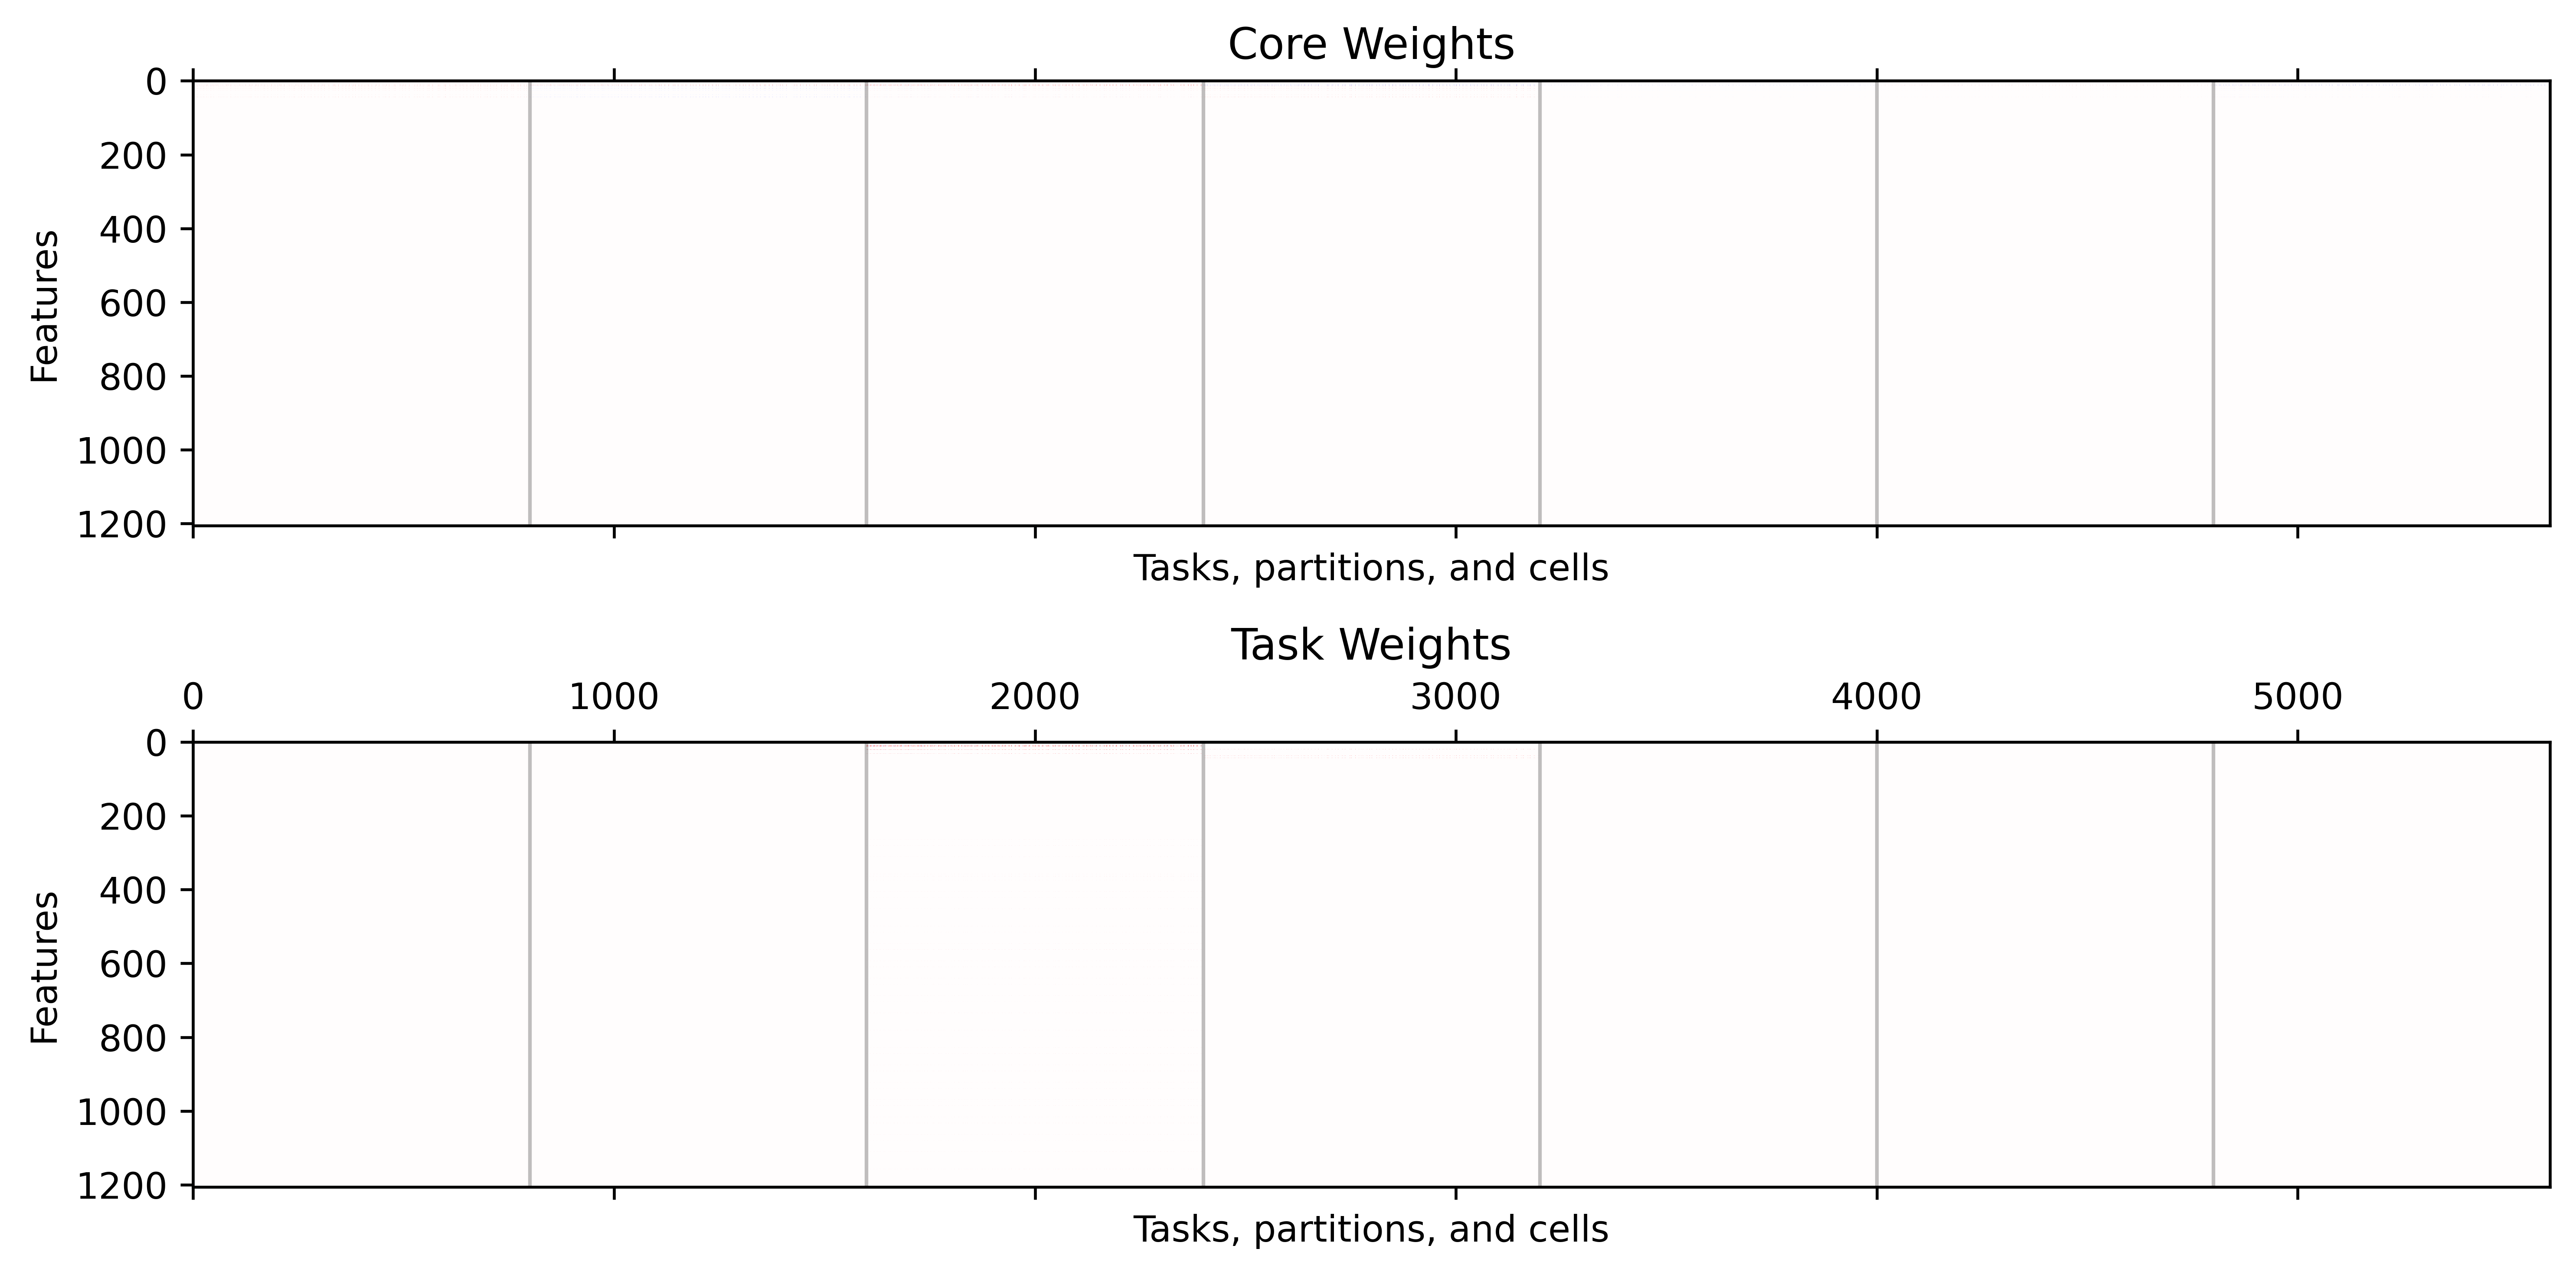

Number of nonzero core weights: 11
Number of nonzero task weights: [0, 0, 49, 1, 0, 0, 0]: 50


In [ ]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model, dpi=600)

In [ ]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

dl_model = DirtyModel(
    alpha=0.03,  # shared penalty
    beta=0.02,  # task-specific penalty
)
dl_model.fit(x_train_out, y_train_out, train_mask_out)

/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/mutar/solvers.py:44: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  warnings.warn('Objective did not converge.' +


DirtyModel(alpha=0.03, beta=0.02)

Core features: 15
Task features: [0, 0, 85, 7, 0, 0, 1]: 93


,train,val,test
task 0,0.841,0.777,0.602
task 1,0.746,0.611,0.595
task 2,0.409,0.419,0.402
task 3,0.664,0.688,0.648
task 4,0.977,1.136,1.353
task 5,0.979,1.458,1.036
task 6,0.953,0.986,0.938


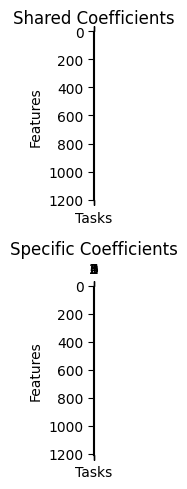

In [ ]:
dl_plot(dl_model)

dl_res = score_dl(
    dl_model,
    x_train_out,
    y_train_out,
    x_val_out,
    y_val_out,
    x_test_out,
    y_test_out,
    masks=[train_mask_out, val_mask_out, test_mask_out],
)
display(dl_res.round(3))

In [ ]:
feats_df = compare_feats(
    jp_model, dl_model, x_train, y_train, x_val, y_val, x_test, y_test
)
feats_df.xs("test", level=1).round(3)

,0,1,2,3,4,5,6
joplen,0.182,0.213,0.082,0.152,1.307,1.036,0.230
dl,0.229,0.237,0.037,0.117,1.307,1.036,0.229


In [ ]:
pd.DataFrame(scores, index=names).round(3)

NameError: name 'names' is not defined

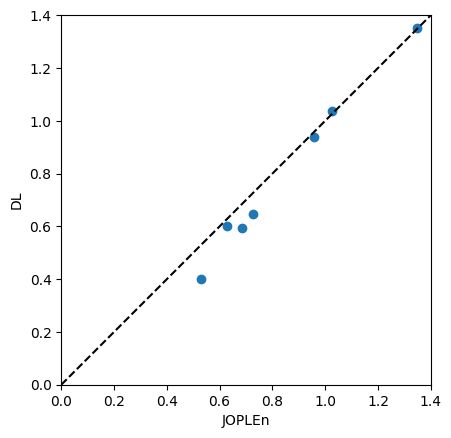

In [ ]:
scatter_test(jp_res, dl_res, "JOPLEn", "DL")

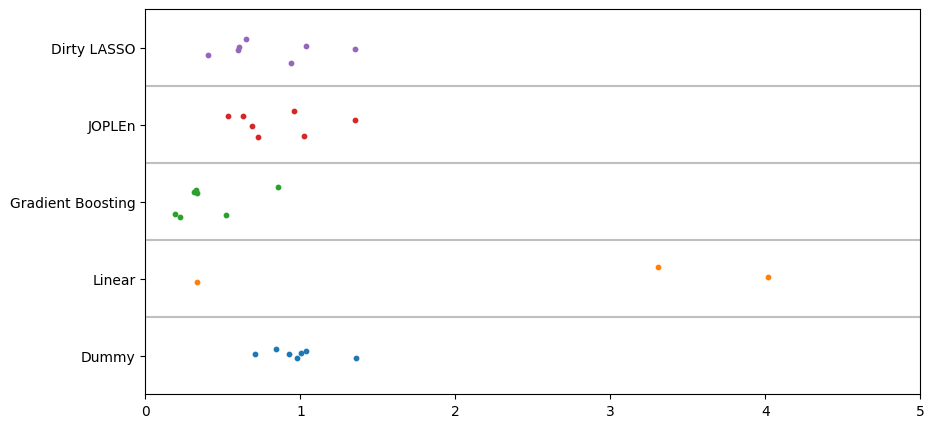

In [ ]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 1.0, "s": 10},
)
plt.yticks(np.arange(len(NAMES)), NAMES)


plt.xlim(0, 5)

plt.show()

In [ ]:
# save results for plotting
save_results(
    "nanoparticle",
    jp_res,
    dl_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
)